In [22]:
# ============================================
# MOUNT GOOGLE DRIVE (FOR GOOGLE COLAB)
# ============================================
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully!\n")

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully!



In [23]:
# ============================================
# CONFIGURATION - UPDATE THESE PATHS
# ============================================
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_classifier_model.keras'
LABELS_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_labels.json'

# ============================================
# LOAD MODEL AND LABELS
# ============================================
print("Loading trained model...")
if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model file not found at {MODEL_PATH}")
    print("   Make sure you've trained the model first (Step 3)")
else:
    model = load_model(MODEL_PATH)
    print("✓ Model loaded successfully!")

print("Loading coin labels...")
if not os.path.exists(LABELS_PATH):
    print(f"❌ ERROR: Labels file not found at {LABELS_PATH}")
else:
    with open(LABELS_PATH, 'r') as f:
        class_labels = json.load(f)
    print(f"✓ Labels loaded successfully!")
    print(f"✓ Found {len(class_labels)} coin types in collection\n")

Loading trained model...
✓ Model loaded successfully!
Loading coin labels...
✓ Labels loaded successfully!
✓ Found 23 coin types in collection



In [24]:
# ============================================
# PREDICTION FUNCTION
# ============================================
def predict_coin(image_path, show_image=True, top_k=3):
    """
    Predict the coin type from an image

    Parameters:
    - image_path: Path to the coin image
    - show_image: Whether to display the image
    - top_k: Number of top predictions to show

    Returns:
    - prediction: The predicted coin type
    - confidence: Confidence percentage
    """

    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100

    # Get top predictions
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]

    # Display results
    print("="*60)
    print(f"Image: {os.path.basename(image_path)}")
    print("="*60)

    print(f"\n🏆 PREDICTION: {class_labels[str(predicted_class)]}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%\n")

    # Decision threshold
    THRESHOLD = 75.0  # Adjust this based on your needs

    if confidence >= THRESHOLD:
        print(f"✅ HIGH CONFIDENCE: You already have this coin!")
        print(f"   → Let this coin go")
        decision = "REJECT"
    else:
        print(f"⚠️  LOW CONFIDENCE: This might be a new coin!")
        print(f"   → Consider keeping it for manual verification")
        decision = "KEEP (verify manually)"

    print(f"\nTop {top_k} predictions:")
    print("-" * 60)
    for idx in top_indices:
        print(f"  {class_labels[str(idx)]:<40} {predictions[0][idx]*100:>6.2f}%")
    print("-" * 60)

    # Show image
    if show_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(Image.open(image_path))
        plt.axis('off')
        plt.title(f"Predicted: {class_labels[str(predicted_class)]}\n"
                 f"Confidence: {confidence:.2f}% - Decision: {decision}",
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

    return class_labels[str(predicted_class)], confidence, decision

In [25]:
# ============================================
# BATCH PREDICTION FUNCTION
# ============================================
def predict_multiple_coins(image_folder):
    """
    Predict coin types for all images in a folder
    """
    image_files = [f for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {image_folder}")
        return

    print(f"\nProcessing {len(image_files)} images...\n")

    results = []
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        coin_type, confidence, decision = predict_coin(img_path, show_image=False)
        results.append({
            'image': img_file,
            'prediction': coin_type,
            'confidence': confidence,
            'decision': decision
        })
        print("\n")

    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    keep_count = sum(1 for r in results if 'KEEP' in r['decision'])
    reject_count = len(results) - keep_count

    print(f"Total coins analyzed: {len(results)}")
    print(f"Coins to KEEP (new): {keep_count}")
    print(f"Coins to REJECT (duplicates): {reject_count}")

    return results


COIN CLASSIFIER - PREDICTION MODE

Example 1: Single Coin Prediction
------------------------------------------------------------
Image: coin_check.jpg

🏆 PREDICTION: coin_18
📊 CONFIDENCE: 97.98%

✅ HIGH CONFIDENCE: You already have this coin!
   → Let this coin go

Top 3 predictions:
------------------------------------------------------------
  coin_18                                   97.98%
  coin_23                                    0.77%
  coin_12                                    0.55%
------------------------------------------------------------


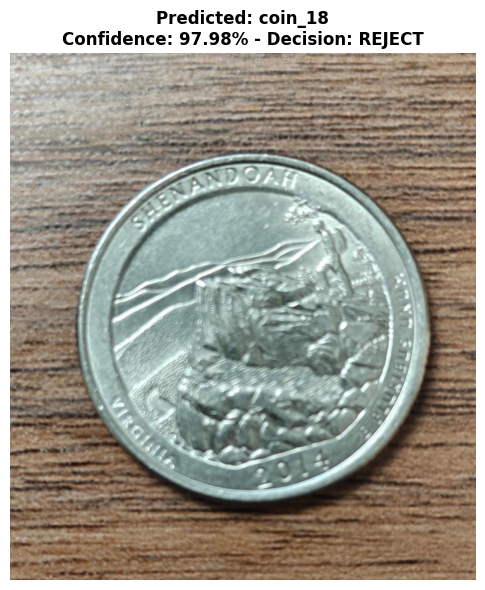


PREDICTION COMPLETE


In [26]:
# ============================================
# USAGE EXAMPLES
# ============================================
if __name__ == "__main__":
    print("\n" + "="*60)
    print("COIN CLASSIFIER - PREDICTION MODE")
    print("="*60 + "\n")

    # Example 1: Single coin prediction
    print("Example 1: Single Coin Prediction")
    print("-" * 60)

    # UPDATE THIS PATH to your test image
    test_image = "/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_check/coin_check.jpg"

    # Check if file exists
    if os.path.exists(test_image):
        predict_coin(test_image, show_image=True, top_k=3)
    else:
        print(f"⚠️  Please update 'test_image' path in the script")
        print(f"   Current path: {test_image}")
        print(f"   This file does not exist.\n")

    # Example 2: Batch prediction
    # Uncomment below to process multiple coins at once
    """
    print("\n\nExample 2: Batch Prediction")
    print("-" * 60)
    test_folder = "path/to/folder/with/new_coins"

    if os.path.exists(test_folder):
        results = predict_multiple_coins(test_folder)
    else:
        print(f"⚠️  Folder not found: {test_folder}")
    """

    print("\n" + "="*60)
    print("PREDICTION COMPLETE")
    print("="*60)